Bayesian Classifier, 99% of the code copied from "Feature Extraction and model analysis", omitting unnecessary elements ofcourse

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# make plots look betters
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (8,6)
# plt.rcParams['figure.dpi'] = (300)
plt.rcParams['font.size'] = 12

comments = pd.read_pickle('../../toxic_comment_data/combined_train_data.csv')

In [50]:
comments.head()

,Comment,Date,Insult,Raw_Length,True_Length,Norm_True_Length,Weekday,Day,Month,Year,Hour,Minute,Second
0,"""You fuck your dad.""",2012-06-18 19:21:55,1,20,20,0.001064,0,18,6,2012,19,21,55
1,"""i really don't understand your point.\xa0 It ...",2012-05-28 19:22:15,0,92,89,0.006306,0,28,5,2012,19,22,15
2,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...",2012-06-19 09:47:53,0,728,377,0.028187,1,19,6,2012,9,47,53
3,"""@SDL OK, but I would hope they'd sign him to ...",2012-06-20 17:12:26,0,245,245,0.018158,2,20,6,2012,17,12,26
4,"""Yeah and where are you now?""",2012-05-03 01:26:28,0,29,29,0.001747,3,3,5,2012,1,26,28


Feature Extraction:  note that the comments imported will have to be combined_train_data.csv

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

# allows us to select a column by name from a data frame and return it as a nparray of type string
class TextExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def transform(self, data):
        return np.asarray(data[self.column]).astype(str)
    
    # not used
    def fit(self, *_):
        return self 

# allows us to select a column by name from a data frame and return it as a nparray of the specified type
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column, dtype):
        self.dtype = dtype
        self.column = column

    def transform(self, data):
        data = np.asarray(data[self.column]).astype(self.dtype)
         
        # note: reshaping is necessary because otherwise sklearn
        # interprets 1-d array as a single sample
        # reshapes from row vector to column vector
        data = data.reshape(data.size, 1) 
        return data
    
    # not used
    def fit(self, *_):
        return self

In [52]:

char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char')),
    ('tfidf', TfidfTransformer())
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('tfidf', TfidfTransformer())
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

# set the classifier
#--** this is where to change the classifier **--
classifier = BernoulliNB()

# set the feature selection (these params can also be grid searched)
select = SelectPercentile(score_func=chi2, percentile=10)

pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

In [53]:
pipeline.fit(comments, comments.Insult);

-reserved-

In [54]:
test = pd.read_pickle("../../toxic_comment_data/labeled_test_set_with_features.csv")
predicted = pipeline.predict(test)
np.mean(predicted == test.Insult)

0.680089485458613

In [55]:
parameters = {'union__char_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2)] # the range of the n-grams
             }

# the names are important, e.g. vect__ corresponds to the name given to the class in the pipeline,
# while "ngram_range" is a parameter for the class, i.e. CountVectorizer

gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1) # run the grid search on the chosen pipeline
gs_clf = gs_clf.fit(comments, comments.Insult) 

In [56]:
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.8142750373692078
{'union__char_ngrams__vectorizer__ngram_range': (1, 1)}


In [57]:
test = pd.read_pickle("../../toxic_comment_data/labeled_test_set_with_features.csv")
predicted = gs_clf.predict(test)
np.mean(predicted == test.Insult)

0.680089485458613

Plotting the ROC curve

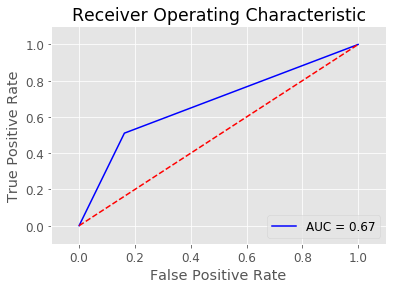

In [58]:
# make a function for plotting the roc
def plot_roc(test_labels, predicted_labels):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels,predicted_labels)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');
    
plot_roc(test.Insult, predicted)

Utilize grid search to optimize 

In [59]:
from timeit import default_timer as timer

start = timer() # start timer so we can see how long it takes

# IF YOU RUN THIS AS IS IT WILL TAKE AN HOUR OR TWO TO FINISH
parameters = {  'union__char_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)], # the range of the n-grams
                'union__char_ngrams__vectorizer__stop_words': [None, 'english'], # remove stopwords or not
                'union__char_ngrams__tfidf__use_idf': (True, False), # use idf or not
                'union__word_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
                'union__word_ngrams__vectorizer__stop_words': [None, 'english'],
                'union__word_ngrams__tfidf__use_idf': (True, False),
                'classifier__fit_prior': [1, 0.50, .1, 0.01, 0.001],
                'classifier__binarize' : [1, 0.50, .1, 0.01, 0.001],
                'classifier__alpha' : [1, 0.50, .1, 0.01, 0.001], # change alpha hyperparameter
                'classifier__fit_prior' : [False,True],
             }

# The names here are very important. the intuition is that they follow from the pipeline hierarchy.
# For example, to access the ngram_range parameter for CountVectorizer, you have to follow the hierarchy
# starting at the feature union, and use the corresponding names with two '__' between each.

# So the format is: name__name__(...)__parameter
# The last name on the string e.g. "ngram_range" is a parameter for the class, in this case, CountVectorizer

gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1) # run the grid search on the chosen pipeline
gs_clf = gs_clf.fit(comments, comments.Insult) 

end = timer()

#information dump
print("Gridsearch took:")
print(end - start)
print("Training time:", round((end-start)/60/60,2), "hours")
print("best score")
print(gs_clf.best_score_)
print("best parameters")
print(gs_clf.best_params_)

#save results for later
from sklearn.externals import joblib
joblib.dump(gs_clf, 'BernoulliBayesianClassifier_Results_3.pkl');

Gridsearch took:
6534.346376376998
Training time: 1.82 hours
best score
0.8389387144992526
best parameters
{'classifier__alpha': 0.1, 'classifier__binarize': 0.01, 'classifier__fit_prior': True, 'union__char_ngrams__tfidf__use_idf': True, 'union__char_ngrams__vectorizer__ngram_range': (1, 3), 'union__char_ngrams__vectorizer__stop_words': None, 'union__word_ngrams__tfidf__use_idf': False, 'union__word_ngrams__vectorizer__ngram_range': (1, 2), 'union__word_ngrams__vectorizer__stop_words': 'english'}


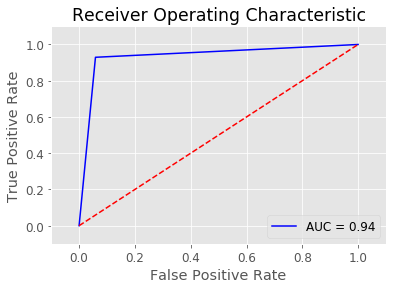

In [60]:
predicted = gs_clf.predict(comments)
plot_roc(comments.Insult, predicted)

Now utilize randomized grid search to see if you get a result [to be implemented]